### Importing the dependencies to work with

In [93]:
import lmfit
import rampy as rp #Charles' libraries and functions

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px


###  Reading the data file

In [94]:
# Load Data
import os
dir_name = 'Data/Thylakoids/qg27/'
filename = 'qg27_thyl_XY09'
full_file = os.path.join(dir_name,filename)
data = pd.read_csv(full_file, delimiter = "\t", names=["x", "y"])

In [106]:
import pickle
init_temp = 10
c = 0
for file in os.listdir(dir_name):
    filename = file
    if '_XY' in filename:
        # print(file_num)
        data_temp = init_temp+c
        # print(filename + ' : '+str(data_temp))
        c += 3 
        data = pd.read_csv(full_file, delimiter = "\t", names=["x", "y"])

        print(data)

               x        y
0     3999.36053 -0.15297
1     3998.87839 -0.15294
2     3998.39625 -0.15291
3     3997.91411 -0.15288
4     3997.43197 -0.15285
...          ...      ...
6425   901.60388  1.27664
6426   901.12174  1.27592
6427   900.63960  1.27517
6428   900.15746  1.27441
6429   899.67532  1.27366

[6430 rows x 2 columns]
               x        y
0     3999.36053 -0.15297
1     3998.87839 -0.15294
2     3998.39625 -0.15291
3     3997.91411 -0.15288
4     3997.43197 -0.15285
...          ...      ...
6425   901.60388  1.27664
6426   901.12174  1.27592
6427   900.63960  1.27517
6428   900.15746  1.27441
6429   899.67532  1.27366

[6430 rows x 2 columns]
               x        y
0     3999.36053 -0.15297
1     3998.87839 -0.15294
2     3998.39625 -0.15291
3     3997.91411 -0.15288
4     3997.43197 -0.15285
...          ...      ...
6425   901.60388  1.27664
6426   901.12174  1.27592
6427   900.63960  1.27517
6428   900.15746  1.27441
6429   899.67532  1.27366

[6430 rows x 

### Visualize the Data

In [43]:
fig = px.line(data_frame=data, x=data['x'], y=data['y'])
fig.show()

In [44]:
# Convert Dataframe data to numpy arrays for working with smoothening and correction
data_array = data.to_numpy()
x = data_array[:,0]
y = data_array[:,1]


For smoothening

In [45]:
# Incase to smooth
# y_smo = rp.smooth(data_array[:,0],data_array[:,1],method="savgol",window_length=5,polyorder=3)
# y_smo = rp.smooth(x,y,method="whittaker",Lambda=10**0.5)

Check the smoothen and raw data

In [46]:
# Check the plots before and after smooth
# plt.figure(figsize=(8,8))
# plt.subplot(2,1,1)
# plt.plot(x, y)
# plt.title("Raw Data")
# plt.subplot(2,1,2)
# plt.title("Smoothen Data")
# plt.plot(data_array[:,0], y_smo)

#### Select the region of Interest (ROI)

In [47]:
roi = np.array([(1347,1365),(1774,1800)])
roi[1,1]

1800

### Baseline Fitting and trimming the data

In [48]:
# Base line correction
y_corr, y_base = rp.baseline(x,y,roi,'poly',polynomial_order=3)

# Trim the data
x_fit = x[np.where((x > roi[0,0])&(x < roi[1,1]))]
y_fit = y_corr[np.where((x > roi[0,0])&(x < roi[1,1]))]

Plot the trimmed data

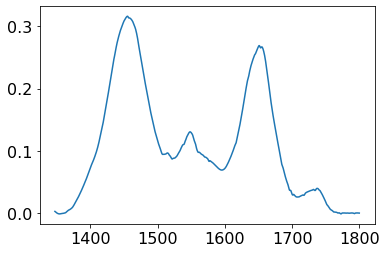

In [49]:
plt.figure()
plt.plot(x_fit,y_fit)
# plt.xlim([1347,1849])
# plt.title("Trimmed Data non-normalized")

Normalized the trimmed data and plot

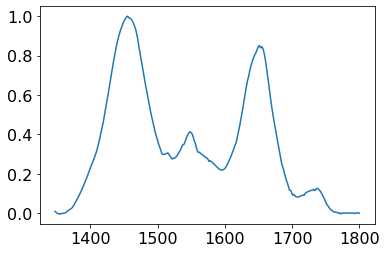

In [50]:
y_fit_norm_intensity = rp.normalise(y_fit,x=x_fit,method="intensity")
plt.plot(x_fit,y_fit_norm_intensity)
# plt.title("Trimmed Data normalized to max intensity")


Text(0.5, 1.0, 'B) signal to fit')

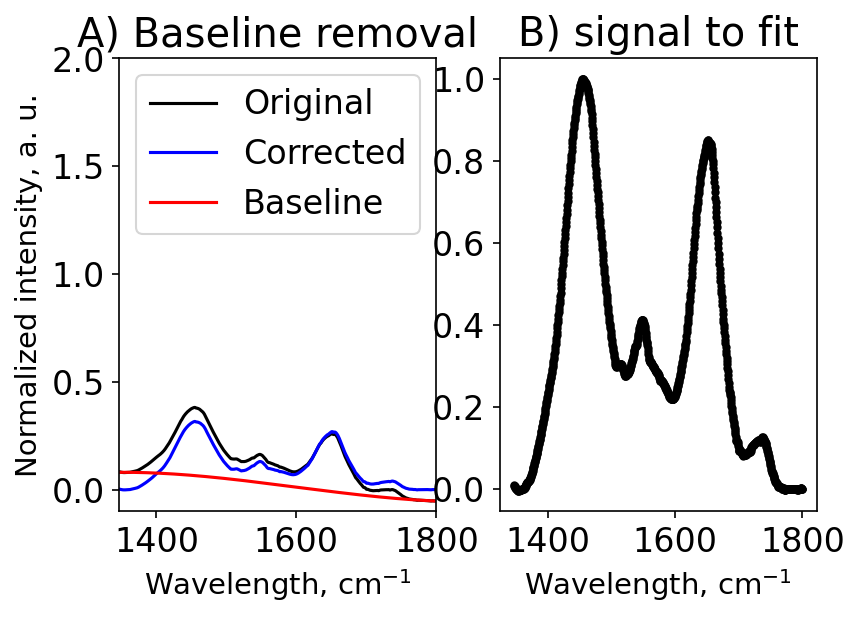

In [51]:
# create a new plot for showing the spectrum
plt.figure(dpi=150)
plt.subplot(1,2,1)
inp = plt.plot(x,y,'k-',label='Original')
corr = plt.plot(x,y_corr,'b-',label='Corrected') #we use the sample variable because it is not already normalized...
bas = plt.plot(x,y_base,'r-',label='Baseline')
plt.xlim(roi[0,0],roi[1,1])
plt.ylim(-0.1,2)
plt.xlabel("Wavelength, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
plt.legend()
plt.title('A) Baseline removal')

plt.subplot(1,2,2)
plt.plot(x_fit,y_fit_norm_intensity,'k.')
plt.xlabel("Wavelength, cm$^{-1}$", fontsize = 14)
plt.title('B) signal to fit')
#plt.tight_layout()
# plt.suptitle('Figure 2', fontsize = 14,fontweight = 'bold')

### Replot for quick check for the input paramaters 

In [52]:
arr = np.column_stack((x_fit,y_fit_norm_intensity))
my_array = pd.DataFrame(arr, columns = ['x_fit','y_fit'])
fig = px.line(data_frame=my_array, x=my_array['x_fit'], y=my_array['y_fit'])
fig['layout']['xaxis']['autorange'] = "reversed"
fig.show()

It would be good to check the plot and assign initial parameters in the parameters section for good and faster fit.

### Parameters Section

Make sure to add equal number of parameters as you have used in case of the residual local function . 

In [53]:
params = lmfit.Parameters()
algo = 'leastsq'
#               (Name,  Value,   Vary,   Min,     Max,       Expr)
params.add_many(
                # Protein
                ('a1',   0.1,    True,    0,      0.2,     None), #Amplitude
                ('f1',   1740,   True,   1735,    1755,    None), #position
                ('l1',   5,      True,    1,      50,     None), # FWHM

                ('a2',   0.04,    True,     0,      0.2,    None),   #Amplitude
                ('f2',   1725,   True,   1720,     1745,     None),
                ('l2',    5,    True,    1,       50,    None), 
                # Lipid
                ('a3',   0.9,    True,    0,       1,        None),  # Amplitude
                ('f3',   1654,   True,    1640,   1660,     None),
                ('l3',   20,     True,     10,     40,      None),

                ('a4',   0.9,    True,      0,      1,      None), # Amplitude
                ('f4',   1636,   True,   1630,    1650,     None),
                ('l4',   20,     True,     10,     80,      None), 
                
                ####
                ('a5',   0.3,    True,    0.0,     1,       None), # Amplitude
                ('f5',   1547,   True,    1592,    1505,    None),
                ('l5',   40,     True,     0,      100,     None),

                ('a6',   0.7,    True,     0.0,       1,    None), # Amplitude
                ('f6',   1453,   True,    1425,    1470,    None),
                ('l6',   20,     True,     0,      50,      None),   
                
                ('a7',   0.07,    True,     0.0,    1,      None), # Amplitude
                ('f7',   1378,   True,    1350,    1380,    None),
                ('l7',   10,     True,     0,      10,      None),   
                        
               )
params  

name,value,initial value,min,max,vary
a1,0.10000000,0.1,0.00000000,0.20000000,True
f1,1740.00000,1740,1735.00000,1755.00000,True
l1,5.00000000,5,1.00000000,50.0000000,True
a2,0.04000000,0.04,0.00000000,0.20000000,True
f2,1725.00000,1725,1720.00000,1745.00000,True
l2,5.00000000,5,1.00000000,50.0000000,True
a3,0.90000000,0.9,0.00000000,1.00000000,True
f3,1654.00000,1654,1640.00000,1660.00000,True
l3,20.0000000,20,10.0000000,40.0000000,True
a4,0.90000000,0.9,0.00000000,1.00000000,True


### Run Fit

In [54]:
from Modules.custom_funx import*


In [55]:
result = lmfit.minimize(residual, params, method = algo, args=(x_fit, y_fit_norm_intensity[:,0]))
print(lmfit.fit_report(result))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 179
    # data points      = 940
    # variables        = 21
    chi-square         = 0.20161180
    reduced chi-square = 2.1938e-04
    Akaike info crit   = -7898.45362
    Bayesian info crit = -7796.69014
[[Variables]]
    a1:  0.05713129 +/- 0.02715174 (47.53%) (init = 0.1)
    f1:  1740.99692 +/- 0.83661913 (0.05%) (init = 1740)
    l1:  8.45742320 +/- 2.01639315 (23.84%) (init = 5)
    a2:  0.08283159 +/- 0.01232625 (14.88%) (init = 0.04)
    f2:  1725.76882 +/- 3.83858949 (0.22%) (init = 1725)
    l2:  15.9381409 +/- 2.70678532 (16.98%) (init = 5)
    a3:  0.68396055 +/- 0.42865678 (62.67%) (init = 0.9)
    f3:  1652.49121 +/- 2.62566028 (0.16%) (init = 1654)
    l3:  24.2581985 +/- 3.16479174 (13.05%) (init = 20)
    a4:  0.21569546 +/- 0.34359635 (159.30%) (init = 0.9)
    f4:  1630.27360 +/- 35.4369150 (2.17%) (init = 1636)
    l4:  32.3349125 +/- 7.81477347 (24.17%) (init = 20)
    a5:  0.33738752 +/

### Get all the residuals

In [56]:
yout, peak1,peak2,peak3,peak4,peak5,peak6, peak7 = residual(result.params,x_fit)
res_stack = np.column_stack((yout,peak1,peak2,peak3,peak4,peak5,peak6,peak7))



['Data']


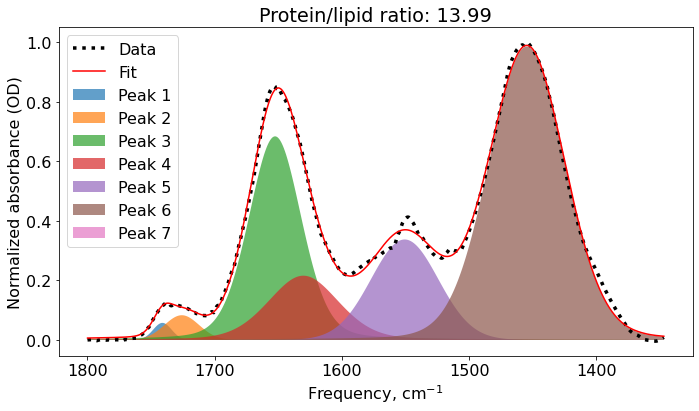

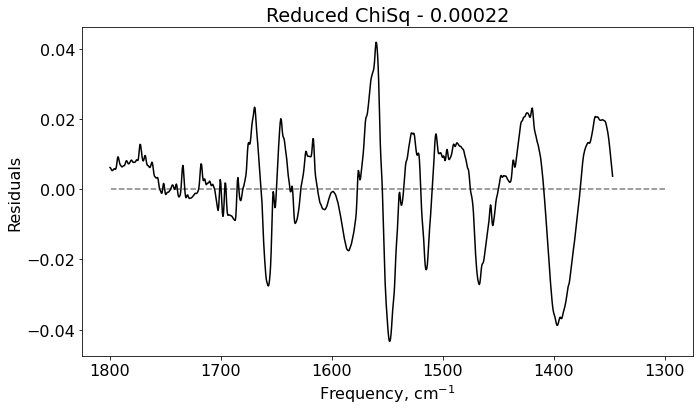

In [57]:
# Create dataframe
res_df = create_residuals_df(res_stack,y_fit_norm_intensity)
# Create Plots
ax = plot_fit(res_df,x_fit)
r = cal_peak(peak1,peak2, peak3, peak4, x_fit)
ax.title( "Protein/lipid ratio: "+str(round(r,2)))
# pip install pyppt
import pyppt as ppt
ppt.add_figure('Left',delete_placeholders=True, replace=True, slide_no=2)
ppt.set_title(filename, slide_no=1)
ppt.title_to_front(slide_no=2)
ax1 = plot_res(x_fit,result.residual)
ax1.title('Reduced ChiSq - '+str(round(result.redchi,5)))
ppt.add_figure('Right', delete_placeholders=True, replace=True)




In [35]:
res = y_fit_norm_intensity - yout
np.savetxt("y_fit_norm_intensity.csv",y_fit_norm_intensity, delimiter=",")
np.savetxt("yout.csv",yout, delimiter=",")
np.savetxt("res.csv",res, delimiter=",")
np.savetxt("x_fit.csv",x_fit, delimiter=",")